The aim here is to predict rating for apps. In the first part, we are trying to train our model to predict rating for the apps which are paid apps and calculate the error rate for our trained model.
In the second part, we are trying to predict rating for the apps with our trained model for apps which are free initially and then are made paid. So, we are checking whether it's popularity remains the same.

Input dataset : https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps#AppleStore.csv

In [1]:
# Importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
#Reading file for ios apps from AppleStore dataset

Path = r'C:\Users\Dhwani\Desktop\AppoMania\AppleStore.csv'
appleStoreDf = pd.read_csv(Path,parse_dates=True)
appleStoreDf.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
appleStoreDf.dtypes

Unnamed: 0            int64
id                    int64
track_name           object
size_bytes            int64
currency             object
price               float64
rating_count_tot      int64
rating_count_ver      int64
user_rating         float64
user_rating_ver     float64
ver                  object
cont_rating          object
prime_genre          object
sup_devices.num       int64
ipadSc_urls.num       int64
lang.num              int64
vpp_lic               int64
dtype: object

In [4]:
#checking for null values

appleStoreDf.isna().sum()

Unnamed: 0          0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

In [5]:
appleStoreDf['previous_rating_count'] = appleStoreDf['rating_count_tot'] - appleStoreDf['rating_count_ver']

In [6]:
appleStoreDf['size_bytes_in_MB'] = appleStoreDf['size_bytes'] / (1024 * 1024.0)

In [7]:
appleStoreDf['isNotFree'] = appleStoreDf['price'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
# Taking features which are required for rating prediction into a temporary dataset
lmDf = appleStoreDf[['size_bytes_in_MB','previous_rating_count','isNotFree','sup_devices.num','ipadSc_urls.num','lang.num','vpp_lic',
                     'user_rating','prime_genre','price']].copy()

In [9]:
lmDf.dtypes

size_bytes_in_MB         float64
previous_rating_count      int64
isNotFree                  int64
sup_devices.num            int64
ipadSc_urls.num            int64
lang.num                   int64
vpp_lic                    int64
user_rating              float64
prime_genre               object
price                    float64
dtype: object

In [10]:
lmDf.count()

size_bytes_in_MB         7197
previous_rating_count    7197
isNotFree                7197
sup_devices.num          7197
ipadSc_urls.num          7197
lang.num                 7197
vpp_lic                  7197
user_rating              7197
prime_genre              7197
price                    7197
dtype: int64

In [11]:
# Taking data where Price > 0 and rating > 0
#user_rating is average of all ratings of previous versions

lmDf = lmDf[(lmDf.price != 0) & (lmDf.user_rating != 0.0)]
lmDf.count()

size_bytes_in_MB         2885
previous_rating_count    2885
isNotFree                2885
sup_devices.num          2885
ipadSc_urls.num          2885
lang.num                 2885
vpp_lic                  2885
user_rating              2885
prime_genre              2885
price                    2885
dtype: int64

In [12]:
lmDf.describe()

,size_bytes_in_MB,previous_rating_count,isNotFree,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,user_rating,price
count,2885.000000,2885.000000,2885.0,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000,2885.000000
mean,249.251070,4048.951127,1.0,37.224610,3.924437,5.303986,0.994454,4.051127,3.958458
std,439.529935,25829.524812,0.0,4.654068,1.854777,7.229553,0.074277,0.731145,8.552687
min,0.562500,0.000000,1.0,11.000000,0.000000,0.000000,0.000000,1.000000,0.990000
25%,35.436523,18.000000,1.0,37.000000,4.000000,1.000000,1.000000,4.000000,1.990000
50%,88.152344,149.000000,1.0,37.000000,5.000000,1.000000,1.000000,4.000000,2.990000
75%,224.845703,1257.000000,1.0,40.000000,5.000000,8.000000,1.000000,4.500000,4.990000
max,3839.463867,698384.000000,1.0,47.000000,5.000000,58.000000,1.000000,5.000000,299.990000


In [13]:
# Label encoding for prime_genre

from sklearn.preprocessing import LabelEncoder
obj = LabelEncoder()
lmDf["prime_genre"] = obj.fit_transform(lmDf["prime_genre"].astype('object'))

y = lmDf[['user_rating']].copy()
X = lmDf.drop('user_rating',axis=1)

X.head()

,size_bytes_in_MB,previous_rating_count,isNotFree,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,prime_genre,price
0,96.119141,21266,1,38,5,10,1,7,3.99
5,9.999955,2737,1,47,5,1,1,7,0.99
8,46.968750,1113,1,37,5,1,1,21,9.99
9,66.779297,7845,1,38,0,10,1,7,3.99
10,47.320312,72703,1,38,4,11,1,7,4.99


In [14]:
X.count()

size_bytes_in_MB         2885
previous_rating_count    2885
isNotFree                2885
sup_devices.num          2885
ipadSc_urls.num          2885
lang.num                 2885
vpp_lic                  2885
prime_genre              2885
price                    2885
dtype: int64

In [15]:
lmDf = pd.get_dummies(lmDf)
lmDf.dtypes

size_bytes_in_MB         float64
previous_rating_count      int64
isNotFree                  int64
sup_devices.num            int64
ipadSc_urls.num            int64
lang.num                   int64
vpp_lic                    int64
user_rating              float64
prime_genre                int64
price                    float64
dtype: object

In [16]:
#Spliting dataset into train and test data

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X.values, y, random_state=1)

lm = LinearRegression()
lm.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
Predict_rating_train = lm.predict(X_train)
Predict_rating_test = lm.predict(X_test)

Text(0,0.5,'Standardized residuals')

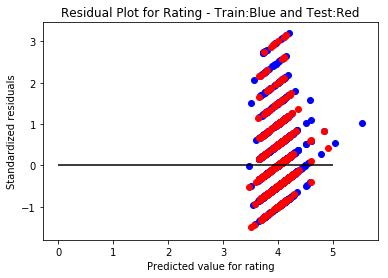

In [54]:
#Residual plot for rating
plt.scatter(Predict_rating_train,np.subtract(Predict_rating_train,Y_train.values),c='b')
plt.scatter(Predict_rating_test,np.subtract(Predict_rating_test,Y_test.values),c='r')
plt.hlines(y=0,xmin=0,xmax=5)

plt.title('Residual Plot for Rating - Train:Blue and Test:Red')
plt.xlabel('Predicted value for rating')
plt.ylabel('Standardized residuals')

In [19]:
# Calculating error rate

ratingErrorTest = round(np.mean(np.subtract(Y_test.values,Predict_rating_test) ** 2),3)
print(ratingErrorTest)

0.53


In [20]:
ratingErrorTrain = round(np.mean(np.subtract(Y_train.values,Predict_rating_train) ** 2),3)
print(ratingErrorTrain)

0.504


In [21]:
#Calculating prediction score

print(lm.score(X_test,Y_test))

0.03061638498342445


In [22]:
print(lm.score(X_train,Y_train))

0.0500449535696339


In [23]:
# Applying Random forest regression model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import cross_val_score, cross_validate

max_depth = 20
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, Y_train)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, Y_train)

# Predict on new data
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

C:\Users\Dhwani\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [24]:
print(y_multirf)

[[3.91425945]
 [4.04735897]
 [3.845     ]
 [3.31388888]
 [4.31266391]
 [4.32      ]
 [3.27      ]
 [4.315     ]
 [3.8155    ]
 [4.24205882]
 [4.14624274]
 [4.04321429]
 [3.8       ]
 [3.735     ]
 [4.53178293]
 [4.21216667]
 [3.9       ]
 [4.155     ]
 [4.16136535]
 [3.81406114]
 [4.41500664]
 [4.16      ]
 [4.08352282]
 [4.21734878]
 [4.12      ]
 [4.48117147]
 [4.01242348]
 [4.23695631]
 [3.735     ]
 [4.34956769]
 [4.005     ]
 [3.36777778]
 [4.4288896 ]
 [3.82      ]
 [3.83      ]
 [4.3656159 ]
 [4.10972973]
 [3.315     ]
 [4.04002535]
 [4.25522436]
 [4.14953764]
 [4.32789617]
 [3.55825434]
 [4.06229829]
 [4.34990445]
 [3.89980042]
 [4.22539186]
 [3.625     ]
 [4.26700894]
 [4.16534383]
 [4.42      ]
 [4.17960854]
 [4.51242424]
 [3.31466667]
 [4.28      ]
 [4.08116658]
 [4.3       ]
 [4.43282753]
 [3.98469779]
 [3.77857282]
 [4.36190647]
 [4.435     ]
 [4.19081395]
 [4.21813571]
 [4.15      ]
 [3.725     ]
 [4.39210172]
 [4.26      ]
 [4.16321037]
 [4.10465188]
 [4.11594978]
 [4.54

# Let's test our trained model with the ratings of apps which are free for now

In [25]:
#Reading file for price prediction

Path = r'C:\Users\Dhwani\Desktop\AppoMania\price_prediction_apple.csv'
pricePrediction = pd.read_csv(Path,parse_dates=True)
pricePrediction.head()

,predicted_price
0,3
1,2
2,1
3,0
4,3


In [26]:
pricePrediction.isna().sum()

predicted_price    0
dtype: int64

In [27]:
pricePrediction.count()

predicted_price    3383
dtype: int64

In [28]:
# Let's take rating for free apps

yFreeAppsRating = appleStoreDf['user_rating'][(appleStoreDf.price == 0) & (appleStoreDf.user_rating != 0)]

In [29]:
# Let's take features of the free apps

XFreeAppsFeatures = appleStoreDf[['user_rating','rating_count_tot','prime_genre','cont_rating']].copy()
XFreeAppsFeatures = XFreeAppsFeatures[(appleStoreDf.price == 0) & (appleStoreDf.user_rating != 0)]

XFreeAppsFeatures['cont_rating'] = XFreeAppsFeatures['cont_rating'].astype('object').str.replace('+', '')
XFreeAppsFeatures['cont_rating'] = pd.to_numeric(XFreeAppsFeatures['cont_rating'])

obj = LabelEncoder()
XFreeAppsFeatures["prime_genre"] = obj.fit_transform(XFreeAppsFeatures["prime_genre"].astype('object'))
XFreeAppsFeatures.head()

,user_rating,rating_count_tot,prime_genre,cont_rating
1,4.0,161065,15,4
2,3.5,188583,22,4
3,4.0,262241,17,12
4,4.5,985920,16,4
6,4.0,119487,5,4


In [30]:
XFreeAppsFeatures.count()

user_rating         3383
rating_count_tot    3383
prime_genre         3383
cont_rating         3383
dtype: int64

In [31]:
XFreeAppsFeatures.isna().sum()

user_rating         0
rating_count_tot    0
prime_genre         0
cont_rating         0
dtype: int64

In [32]:
# Feeding predicted price as input

XFreeAppsFeatures.reset_index(inplace=True)
XFreeAppsFeatures['predicted_price'] = pricePrediction.predicted_price

In [33]:
XFreeAppsFeatures.count()

index               3383
user_rating         3383
rating_count_tot    3383
prime_genre         3383
cont_rating         3383
predicted_price     3383
dtype: int64

In [34]:
XFreeAppsFeatures.isna().sum()

index               0
user_rating         0
rating_count_tot    0
prime_genre         0
cont_rating         0
predicted_price     0
dtype: int64

In [35]:
XFreeAppsFeaturesTrain = XFreeAppsFeatures.drop(columns=['user_rating','index'])

In [36]:
# Let's take features of paid apps

XPaidAppsFeatures = appleStoreDf[['user_rating','rating_count_tot','prime_genre','cont_rating','price']].copy()
XPaidAppsFeatures = XPaidAppsFeatures[(appleStoreDf.price != 0) & (appleStoreDf.user_rating != 0)]

In [37]:
XPaidAppsFeatures.head()

,user_rating,rating_count_tot,prime_genre,cont_rating,price
0,4.0,21292,Games,4+,3.99
5,4.0,8253,Games,4+,0.99
8,4.5,1117,Utilities,4+,9.99
9,4.0,7885,Games,4+,3.99
10,4.5,76720,Games,4+,4.99


In [38]:
# Applying label encoding for prime_genre

XPaidAppsFeatures['cont_rating'] = XPaidAppsFeatures['cont_rating'].astype('object').str.replace('+', '')
XPaidAppsFeatures['cont_rating'] = pd.to_numeric(XPaidAppsFeatures['cont_rating'])

obj = LabelEncoder()
XPaidAppsFeatures["prime_genre"] = obj.fit_transform(XPaidAppsFeatures["prime_genre"].astype('object'))
XPaidAppsFeatures.head()

,user_rating,rating_count_tot,prime_genre,cont_rating,price
0,4.0,21292,7,4,3.99
5,4.0,8253,7,4,0.99
8,4.5,1117,21,4,9.99
9,4.0,7885,7,4,3.99
10,4.5,76720,7,4,4.99


In [39]:
XPaidAppsFeatures.count()

user_rating         2885
rating_count_tot    2885
prime_genre         2885
cont_rating         2885
price               2885
dtype: int64

In [40]:
yFreeAppsRating.count()

3383

In [41]:
XFreeAppsFeaturesTrain.count()

rating_count_tot    3383
prime_genre         3383
cont_rating         3383
predicted_price     3383
dtype: int64

In [42]:
XPaidAppsFeaturesTrain = XPaidAppsFeatures.drop(columns=['user_rating'])

In [43]:
# Training linear regression model with feature of paid apps

lm.fit(XPaidAppsFeaturesTrain,XPaidAppsFeatures.user_rating)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,0,'Prime genre')

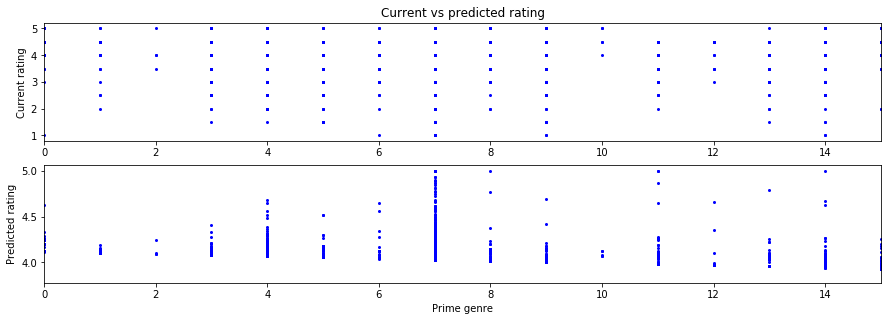

In [44]:
yrange = [0,15]
fsize =15

plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.xlim(yrange)
plt.scatter(XFreeAppsFeatures.prime_genre,yFreeAppsRating,c='b',s=4,alpha=1)

plt.title('Current vs predicted rating')
plt.ylabel('Current rating')
#plt.xlabel('actual rating')


plt.subplot(4,1,2)
plt.xlim(yrange)

plt.scatter(XFreeAppsFeatures.prime_genre,np.clip(lm.predict(XFreeAppsFeaturesTrain),
                        XFreeAppsFeatures['user_rating'].min(), XFreeAppsFeatures['user_rating'].max()),c='b',s=4,alpha=1)

#plt.title('Residual plot')
plt.ylabel('Predicted rating')
plt.xlabel('Prime genre')


In [45]:
XFreeAppsFeatures['prime_genre'] = obj.inverse_transform(XFreeAppsFeatures['prime_genre'])

C:\Users\Dhwani\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
print(len(XFreeAppsFeatures['prime_genre'].unique()))

23


In [47]:
# Training model with paid apps rating using Random forest regressor

regr_rf.fit(XPaidAppsFeaturesTrain,XPaidAppsFeatures.user_rating)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

Text(0.5,0,'Prime genre')

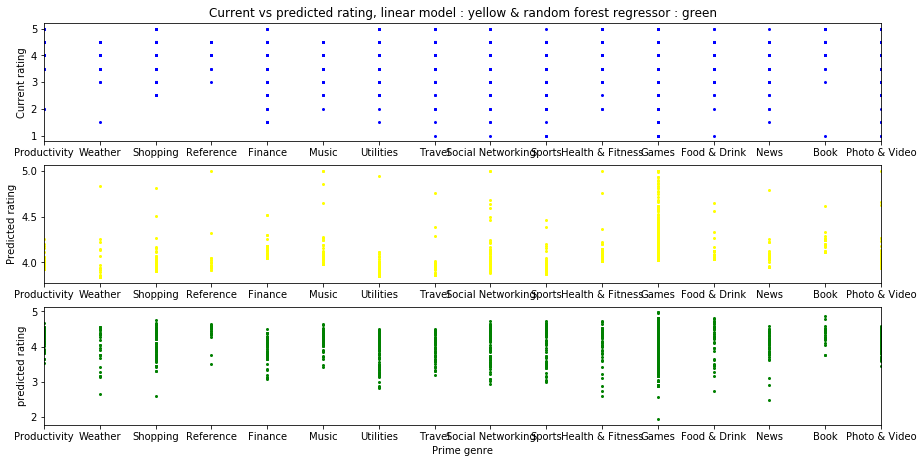

In [48]:
regr_rf.fit(XPaidAppsFeaturesTrain,XPaidAppsFeatures.user_rating)

yrange = [0,15]
fsize =15

plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.xlim(yrange)
plt.scatter(XFreeAppsFeatures.prime_genre,yFreeAppsRating,c='b',s=4,alpha=1)

plt.title('Current vs predicted rating, linear model : yellow & random forest regressor : green')
plt.ylabel('Current rating')
#plt.xlabel('Prime genre')

plt.subplot(4,1,2)
plt.xlim(yrange)
plt.scatter(XFreeAppsFeatures.prime_genre,np.clip(lm.predict(XFreeAppsFeaturesTrain),
                        XFreeAppsFeatures['user_rating'].min(), XFreeAppsFeatures['user_rating'].max()),c='yellow',s=4,alpha=1)

#plt.title('Residual plot')
plt.ylabel('Predicted rating')

plt.subplot(4,1,3)
plt.xlim(yrange)

plt.scatter(XFreeAppsFeatures.prime_genre,np.clip(regr_rf.predict(XFreeAppsFeaturesTrain),
                        XFreeAppsFeatures['user_rating'].min(), XFreeAppsFeatures['user_rating'].max()),c='green',s=4,alpha=1)

#plt.title('Residual plot')
plt.ylabel('predicted rating')
plt.xlabel('Prime genre')

In [49]:
# Applying XGBoost regressor model

from sklearn import cross_validation, tree, linear_model

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

C:\Users\Dhwani\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [51]:
#traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [52]:
print(y_train['user_rating'].max())

5.0


In [53]:
from sklearn.metrics import explained_variance_score

predictions = xgb.predict(X_test)
#predictions = np.clip(xgb.predict(X_test), y_train['user_rating'].min(), y_train['user_rating'].max())
print(explained_variance_score(predictions,y_test))

#print(predictions)

-2.6154224468942977
